In [62]:
%matplotlib inline
import skimage.io as io
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, cross_validation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.externals import joblib

In [72]:
landsat_b1_path = '/Users/yjiang/Downloads/landsat/LE07_L1TP_118061_20100813_20161213_01_T1_B1.TIF'
landsat_b1_ds = gdal.Open(landsat_path, gdal.GA_ReadOnly)
prj = landsat_b1_ds.GetProjection()

source_prj = 'EPSG:4326'
dest_prj = prj
in_path_1 = '/Users/yjiang/Downloads/alos/ALPSRP164767170-L1.5/IMG-HH-ALPSRP164767170.tif'
out_path_1 = '/Users/yjiang/Downloads/alos/ALPSRP164767170-L1.5/test1.tif'
ret = subprocess.check_call(['gdalwarp', '-overwrite', '-s_srs', source_prj, '-t_srs', dest_prj, '-tr', '30', '-30', '-of', 'GTiff', in_path_1, out_path_1])
if ret == 0: 
     print 'warp_1 succeeded'
else:
     print 'warp_1 failed'

in_path_2 = '/Users/yjiang/Downloads/alos/ALPSRP164767160-L1.5/IMG-HH-ALPSRP164767160.tif'
out_path_2 = '/Users/yjiang/Downloads/alos/ALPSRP164767160-L1.5/test2.tif'
ret = subprocess.check_call(['gdalwarp', '-overwrite', '-s_srs', source_prj, '-t_srs', dest_prj, '-tr', '30', '-30', '-of', 'GTiff', in_path_2, out_path_2])
if ret == 0: 
     print 'warp_2 succeeded'
else:
     print 'warp_2 failed' 

out_merge_path = '/Users/yjiang/Downloads/alos/out_merge.tif'
ret = subprocess.check_call(['gdal_merge.py', '-init', '0', '-n', '0', '-o', out_merge_path, out_path_1, out_path_2])
if ret == 0: 
    print 'merge succeeded'
else:
    print 'merge failed'

warp_1 succeeded
warp_2 succeeded
merge succeeded


In [73]:
def getExtent(img_path):
    ds = gdal.Open(img_path, gdal.GA_ReadOnly)
    trans = ds.GetGeoTransform()
    w = ds.RasterXSize    
    h = ds.RasterYSize
    minX = trans[0]
    maxX = trans[0] + w*trans[1]
    minY = trans[3] - h*trans[1]
    maxY = trans[3]
    return [minX, minY, maxX, maxY]

In [74]:
def getOverlap(img1_path, img2_path):
    r1 = getExtent(img1_path)
    r2 = getExtent(img2_path)
    left = max(r1[0], r2[0])
    right = min(r1[2], r2[2])
    bottom = max(r1[1], r2[1])
    top = min(r1[3], r2[3])
    return [left, bottom, right, top]

overlap = getOverlap(landsat_path, out_merge_path)

In [75]:
radar_subset = '/Users/yjiang/Downloads/alos/alos_subset.tif'
ret = subprocess.check_call(['gdalwarp', '-overwrite', '-te', str(overlap[0]), str(overlap[1]), str(overlap[2]), str(overlap[3]), '-of', 'GTiff', out_merge_path, radar_subset])
if ret == 0: 
     print 'subset_alos succeeded'
else:
     print 'subset_alos failed'

subset_alos succeeded


In [76]:
def subset_landsat(in_dir, basename, band, out_dir):
    in_path = '{0}/{1}_{2}.TIF'.format(in_dir, basename, band)
    subset_path = '{0}/{1}_subset.TIF'.format(out_dir, band)
    ret = subprocess.check_call(['gdalwarp', '-overwrite', '-te', str(overlap[0]), str(overlap[1]), str(overlap[2]), str(overlap[3]), '-of', 'GTiff', in_path, subset_path])
    if ret == 0: 
         print 'subset_landsat succeeded'
    else:
         print 'subset_landsat failed'

band1 = 'B1'
band2 = 'B2'
band3 = 'B3'
band4 = 'B4'
in_path = '/Users/yjiang/Downloads/landsat'
out_path = '/Users/yjiang/Downloads/landsat'
basename = 'LE07_L1TP_118061_20100813_20161213_01_T1'
subset_landsat(in_path, basename, band1, out_path)
subset_landsat(in_path, basename, band2, out_path)
subset_landsat(in_path, basename, band3, out_path)
subset_landsat(in_path, basename, band4, out_path)

subset_landsat succeeded
subset_landsat succeeded
subset_landsat succeeded
subset_landsat succeeded


In [77]:
def read(img_path):
    dataset = gdal.Open(img_path, gdal.GA_ReadOnly )
    return dataset

green_ds = read('{0}/{1}_subset.TIF'.format(out_path, band1))
blue_ds = read('{0}/{1}_subset.TIF'.format(out_path, band2))
red_ds = read('{0}/{1}_subset.TIF'.format(out_path, band3))
nir_ds = read('{0}/{1}_subset.TIF'.format(out_path, band4))
radar_ds = read(radar_subset)

green = green_ds.GetRasterBand(1).ReadAsArray()
blue = blue_ds.GetRasterBand(1).ReadAsArray()
red = red_ds.GetRasterBand(1).ReadAsArray()
nir = nir_ds.GetRasterBand(1).ReadAsArray()
radar = radar_ds.GetRasterBand(1).ReadAsArray()
img = np.zeros((nir_ds.RasterYSize, nir_ds.RasterXSize, 5), gdal_array.GDALTypeCodeToNumericTypeCode(red_ds.GetRasterBand(1).DataType))
img[:, :, 0] = green
img[:, :, 1] = blue
img[:, :, 2] = red
img[:, :, 3] = nir
img[:, :, 4] = radar
print radar.shape

(3292, 3110)


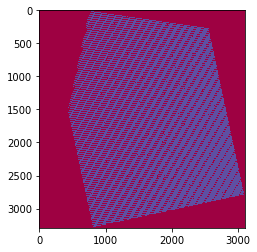

In [78]:
def array_to_raster(array, output_path, ref_path):    
    Image = gdal.Open(ref_path, gdal.GA_ReadOnly)     

    Output = gdal.GetDriverByName('GTiff').Create(output_path, Image.RasterXSize, Image.RasterYSize, 1, gdal.GDT_Float32, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 
    Output.GetRasterBand(1).WriteArray(array)
    Output.FlushCache()  # Write to disk.

# now you can save it to a file
model_path = '/Users/yjiang/Documents/pythonWorkspace/treemap/Data/model_radar_1.joblib'
model = joblib.load(model_path)

rows = img.shape[0]
cols = img.shape[1]
band_num = img.shape[2]

# create mask image
mask_landsat = np.zeros((rows, cols))
mask_landsat[img[:, :, 0]>0] = 1

mask_radar = np.zeros((rows, cols))
mask_radar[img[:, :, 4]>0] = 1

mask = mask_landsat*mask_radar

# making prediction, save and print the output
predict = model.predict(img.reshape(cols*rows, band_num))
output = predict.reshape(rows, cols)*mask

plt.imshow(output, cmap=plt.cm.Spectral)
path = '/Users/yjiang/Downloads/landsat/classification.tif'
# io.imsave(path, output)
array_to_raster(output, path, radar_subset)
plt.show()